# Speech Understanding 
# Lecture 10: Neural Net Speech Recognition

### Mark Hasegawa-Johnson, KCGI

In the last lecture, you learned that an automatic speech recognizer (ASR) converts speech to text
by comparing each frame to a set of stored models, and choosing the best match.

In this lecture, we will use a <a href="https://en.wikipedia.org/wiki/Neural_network">neural network</a> for the model.

1. <a href="#section2">Data preprocessing</a>
1. <a href="#section3">Training the neural network</a>
1. <a href="#section4">Testing the neural network</a>
1. <a href="#homework">Homework</a>

<a id='section2'></a>

## 1. Data preprocessing

When training a neural network, we need a training database $\mathcal{D}=\{(\mathbf{x}_1,y_1),\ldots,(\mathbf{x}_n,y_n)\}$ where $\mathbf{x}$ is what the neural net receives as input, and $y$ is what we want it to generate as output.

First, as inputs, let's use the wideband spectrogram:

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

speech, Fs = librosa.load('train.m4a', sr=8000)

/var/folders/y5/kdcw0kfn2xl71bwrvl50bj1m0000gn/T/ipykernel_32570/2625354938.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a', sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 0, 'Time (Frame Index)')

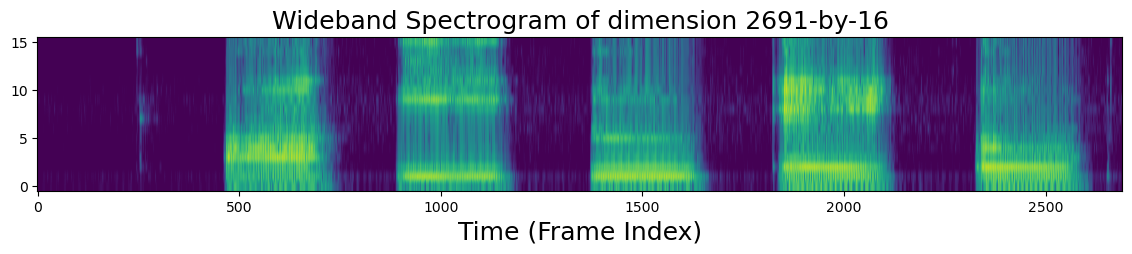

In [2]:
L = int(0.004*Fs)
S = int(0.002*Fs)
mstft = np.abs(np.fft.fft(np.array([speech[m+1:m+1+L]-speech[m:m+L] for m in range(0,len(speech)-L,S)]),axis=1))
sgram = 20*np.log10(np.maximum(0.001*np.amax(mstft), mstft))[:,0:int(L/2)]

fig = plt.figure(figsize=(14,2))
subplot = fig.subplots(1,1)
subplot.imshow(sgram.transpose(),aspect='auto',origin='lower')
subplot.set_title('Wideband Spectrogram of dimension %d-by-%d'%(sgram.shape[0],sgram.shape[1]), fontsize=18)
subplot.set_xlabel('Time (Frame Index)',fontsize=18)

Now, as outputs, let's use VAD to create a per-frame labeling function.  We'll use the following labeling function:

* Silence: y=0
* /a/: y=1
* /i/: y=2
* /u/: y=3
* /e/: y=4
* /o/: y=5

We'll use a 10ms skip for VAD, but only 2ms skip for the spectrogram, so every VAD frame needs to label five frames of y.

Text(0.5, 0, 'Time (Frame Index)')

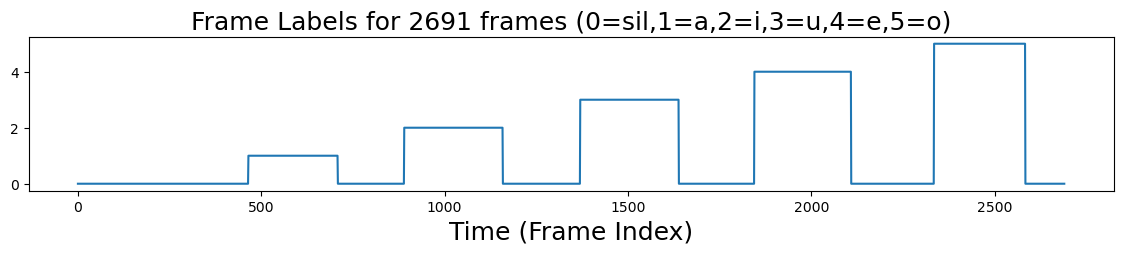

In [3]:
framelength=int(0.025*Fs)
frameskip=int(0.01*Fs)
energy = np.sum(np.square(np.array([speech[m:m+framelength] for m in range(0,len(speech)-framelength,frameskip)])),axis=1)
VAD = [ 1 if energy[m]>0.1*max(energy) else 0 for m in range(len(energy)) ]
startframes = [ m for m in range(1,len(VAD)) if VAD[m-1]==0 and VAD[m]==1 ]
endframes = [ m for m in range(1,len(VAD)) if VAD[m-1]==1 and VAD[m]==0 ]

labels = np.zeros(len(sgram))
for (num,label) in [(1,'a'),(2,'i'),(3,'u'),(4,'e'),(5,'o')]:
    labels[5*startframes[num-1]:5*endframes[num-1]+4] = num

fig = plt.figure(figsize=(14,2))
subplot = fig.subplots(1,1)
subplot.plot(labels)
subplot.set_title('Frame Labels for %d frames (0=sil,1=a,2=i,3=u,4=e,5=o)'%(len(labels)),fontsize=18)
subplot.set_xlabel('Time (Frame Index)',fontsize=18)

<a id='section3'></a>

## 2. Training the neural network

To train and test a neural network, we will use <a href="https://pytorch.org/">pytorch</a>.  Pytorch is the worldwide standard toolkit for training and testing neural networks, and it is open-source.  If you don't have it yet, you can probably install it using this command:

In [4]:
!pip install torch torchvision

We're going to create a neural network model that imitates the cosine-similarity classifier we used last time.  Remember that, if $\mathbf{x}$ is a feature vector, and $\mathbf{w}_i$ is a model vector for the $i^{\text{th}}$ class, the cosine similarity between $\mathbf{x}$ and $\mathbf{w}_i$ is:

$$s(\mathbf{x},\mathbf{w}_i) =\frac{\mathbf{w}_i^T\mathbf{x}}{\Vert\mathbf{x}\Vert\times\Vert\mathbf{w_i}\Vert}$$

We can do this with just a two-layer network:
1. The <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html">LayerNorm</a> layer normalizes the input feature vector, so that it becomes $\frac{\mathbf{x}}{\Vert\mathbf{x}\Vert}$.
2. The <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html">Linear</a> layer computes $\mathbf{A}\mathbf{x}$.   This layer should have a 16-dimensional input (the length of each spectrogram row), and a 6-dimensional output (for 6 output labels: 0=sil, 1=a, 2=i, 3=u, 4=e, 5=o).  The matrix $\mathbf{A}$ is learned by the neural network; we can assume that if the following matrix turns out to have the best performance, it will be learned by the neural network:

$$\mathbf{A}=\left[\frac{\mathbf{w}_0}{\Vert\mathbf{w}_0\Vert},\ldots,\frac{\mathbf{w}_5}{\Vert\mathbf{w}_5\Vert}\right]^T$$

We can create a model with these two layers by encapsulating them in a <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html">Sequential</a> object.

In [12]:
import torch.nn

model = torch.nn.Sequential(torch.nn.LayerNorm(16, dtype=float), torch.nn.Linear(16,6,dtype=float))
print(model)
#print(model[1].Parameter)

Sequential(
  (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=16, out_features=6, bias=True)
)


We will train the neural network to minimize <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">Cross Entropy</a> between the correct labels and the neural net outputs.  Suppose the neural net outputs are $z_k=\frac{\mathbf{w}_k^T\mathbf{x}}{\Vert\mathbf{w}_k\Vert\times\Vert\mathbf{x}\Vert}$, and suppose that the output label should be an integer $y$ such that $0\le y\le 5$.  Cross-entropy loss first uses the softmax function to turn $z_k$ into an estimate of the probability that $y=k$:

$$p_k=\Pr\left(y=k|\mathbf{x}\right) =\frac{e^{z_k}}{\sum_{i=0}^5 e^{z_i}}$$

where

$$z_k = \frac{\mathbf{w}_k^T\mathbf{x}}{\Vert\mathbf{w}_k\Vert\times \Vert\mathbf{x}\Vert}$$
$$\mathbf{z} =\mathbf{A}\frac{\mathbf{x}}{\Vert\mathbf{x}\Vert}$$

Then the cross-entropy loss is the negative log probability of the correct answer:

$$\mathcal{L}(\mathbf{x},y)=-\log p_y$$

### Training a neural network

A neural network is trained using calculus, using one of several different methods that are all based on <a href="https://en.wikipedia.org/wiki/Gradient_descent">gradient descent</a>.  One that works very well is <a href="https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html">Adam</a>.  The basic idea is:

1. Initialize: Choose a loss function and an optimizer
2. Iterate: for each iteration, run the model, calculate the loss, zero the gradient, back-propagate the loss, and modify the neural network weights by taking a step.

Once we're done, we can plot the loss values, to make sure that the loss decreased.



Text(0.5, 0, 'Training iteration number')

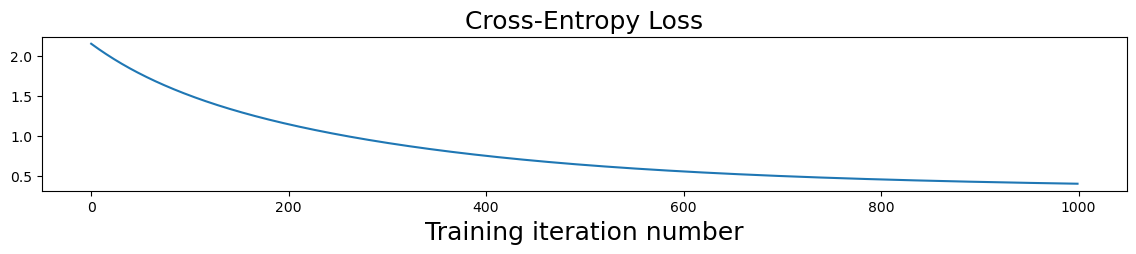

In [13]:
lossfunction = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
lossvalues = np.zeros(1000)
for t in range(1000):
    z = model(torch.tensor(sgram,dtype=float))
    loss = lossfunction( z, torch.tensor(labels, dtype=int) ) 
    lossvalues[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig = plt.figure(figsize=(14,2))
subplot = fig.subplots(1,1)
subplot.plot(lossvalues)
subplot.set_title('Cross-Entropy Loss',fontsize=18)
subplot.set_xlabel('Training iteration number',fontsize=18)

Let's find out how well it learned!  We can use the trained network to label the training waveform.  We will use softmax to calculate the output probabilities:

$$\text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{i=0}^5 e^{z_i}}$$

Then we will use `detach().numpy()` to conver from pytorch to numpy, and `transpose` to put the long axis on the horizontal.

Text(0.5, 0, 'Time (frame number)')

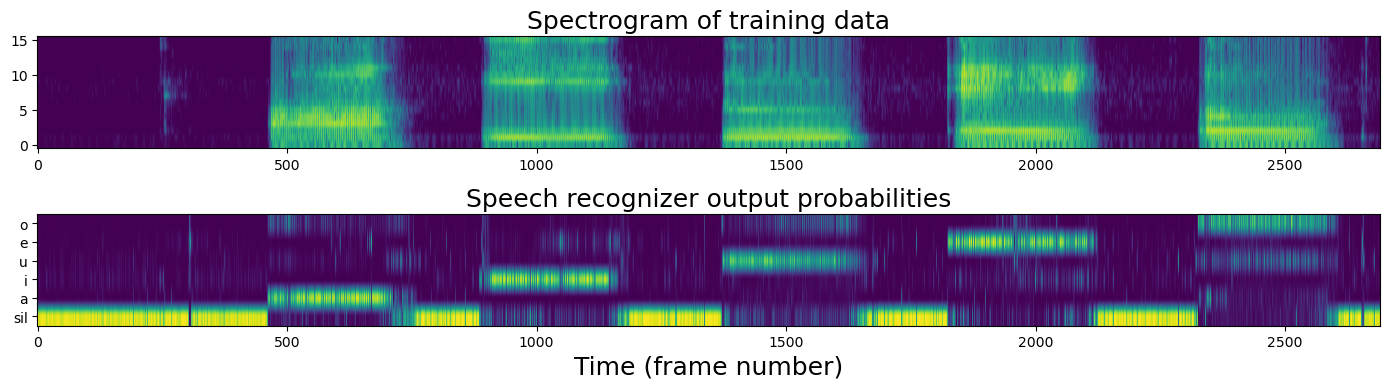

In [14]:
z = model(torch.tensor(sgram,dtype=float))

fig = plt.figure(figsize=(14,4), layout='tight')
subplots = fig.subplots(2,1)
subplots[0].imshow(sgram.transpose(), aspect='auto', origin='lower')
subplots[0].set_title('Spectrogram of training data',fontsize=18)
subplots[1].imshow(z.softmax(-1,dtype=float).detach().numpy().transpose(), aspect='auto', origin='lower')
subplots[1].set_yticks(np.arange(6), ['sil','a','i','u','e','o'])
subplots[1].set_title('Speech recognizer output probabilities',fontsize=18)
subplots[1].set_xlabel('Time (frame number)',fontsize=18)

<a id='section4'></a>

## 3. Testing the neural network

Now let's read in a new waveform, and try to automatically recognize what it says:

In [15]:
testspeech, Fs = librosa.load('test.m4a',sr=8000)

import IPython.display
IPython.display.Audio(testspeech, rate=Fs)

/var/folders/y5/kdcw0kfn2xl71bwrvl50bj1m0000gn/T/ipykernel_32570/2280171301.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  testspeech, Fs = librosa.load('test.m4a',sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 0, 'Time (Frame Index)')

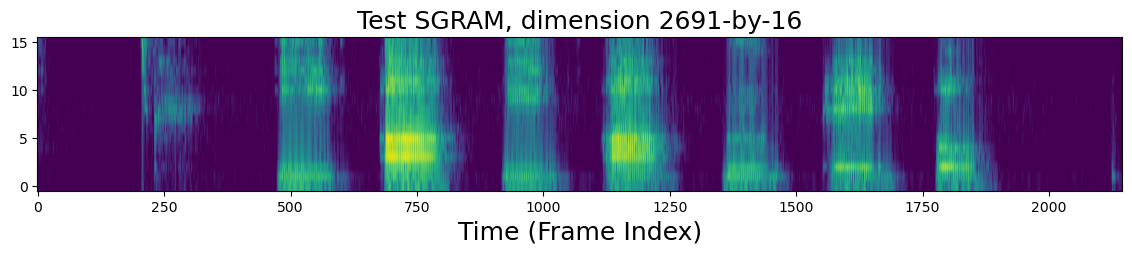

In [16]:
testmstft = np.abs(np.fft.fft(np.array([testspeech[m+1:m+1+L]-testspeech[m:m+L] for m in range(0,len(testspeech)-L,S)]),axis=1))
testsgram = 20*np.log10(np.maximum(0.001*np.amax(testmstft), testmstft))[:,0:int(L/2)]

fig = plt.figure(figsize=(14,2))
subplot = fig.subplots(1,1)
subplot.imshow(testsgram.transpose(),aspect='auto',origin='lower')
subplot.set_title('Test SGRAM, dimension %d-by-%d'%(sgram.shape[0],sgram.shape[1]), fontsize=18)
subplot.set_xlabel('Time (Frame Index)',fontsize=18)

Text(0.5, 0, 'Time (frame number)')

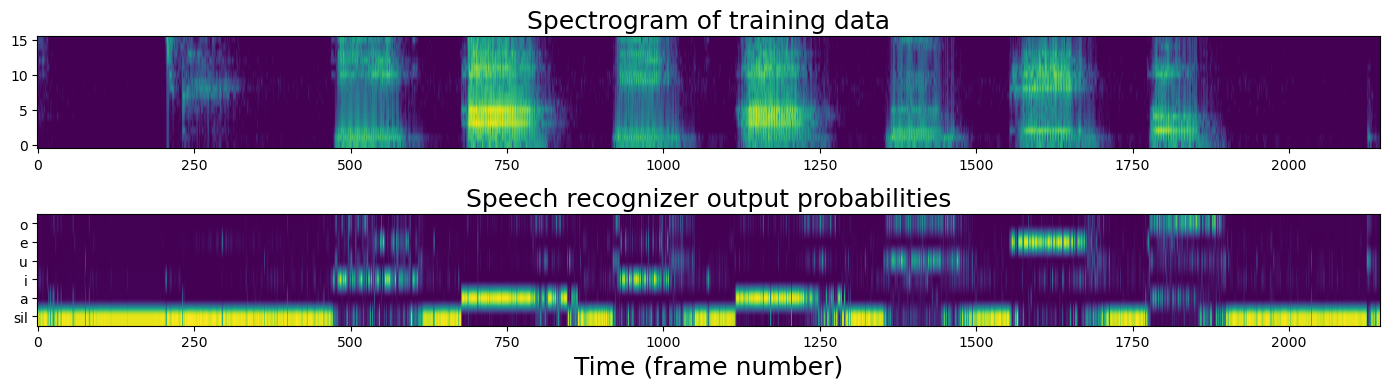

In [17]:
testresults = model(torch.tensor(testsgram,dtype=float))

fig = plt.figure(figsize=(14,4), layout='tight')
subplots = fig.subplots(2,1)
subplots[0].imshow(testsgram.transpose(), aspect='auto', origin='lower')
subplots[0].set_title('Spectrogram of training data',fontsize=18)
subplots[1].imshow(testresults.softmax(-1,dtype=float).detach().numpy().transpose(), aspect='auto', origin='lower')
subplots[1].set_yticks(np.arange(6), ['sil','a','i','u','e','o'])
subplots[1].set_title('Speech recognizer output probabilities',fontsize=18)
subplots[1].set_xlabel('Time (frame number)',fontsize=18)

As you can see, it's getting the right label more often than not.  There is some bouncing around, however, from frame to frame.  

<a id="homework"></a>

## Homework 

Homework will be graded on Github.com.  Edit the file in this directory called `homework9.py`.  

### Homework 10.1

In [18]:
import importlib, homework10
importlib.reload(homework10)
help(homework10.get_features)

Help on function get_features in module homework10:

get_features(waveform, Fs)
    Get features from a waveform.
    @params:
    waveform (numpy array) - the waveform
    Fs (scalar) - sampling frequency.

    @return:
    features (NFRAMES,NFEATS) - numpy array of feature vectors:
        Pre-emphasize the signal, then compute the spectrogram with a 4ms frame length and 2ms step,
        then keep only the low-frequency half (the non-aliased half).
    labels (NFRAMES) - numpy array of labels (integers):
        Calculate VAD with a 25ms window and 10ms skip. Find start time and end time of each segment.
        Then give every non-silent segment a different label.  Repeat each label five times.



Text(0.5, 0, 'Time (frame index)')

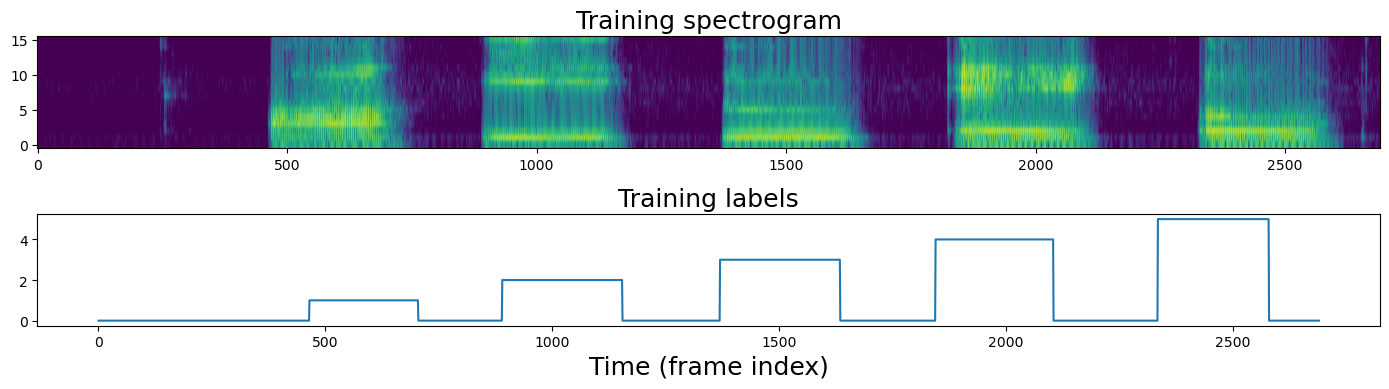

In [20]:
importlib.reload(homework10)
features, labels = homework10.get_features(speech, Fs)
fig = plt.figure(figsize=(14,4), layout='tight')
subplots = fig.subplots(2,1)
subplots[0].imshow(features.transpose(), aspect='auto', origin='lower')
subplots[0].set_title('Training spectrogram',fontsize=18)
subplots[1].plot(labels)
subplots[1].set_title('Training labels',fontsize=18)
subplots[1].set_xlabel('Time (frame index)',fontsize=18)


### Homework 10.2: train_neuralnet

In [21]:
importlib.reload(homework10)
help(homework10.train_neuralnet)

Help on function train_neuralnet in module homework10:

train_neuralnet(features, labels, iterations)
    @param:
    features (NFRAMES,NFEATS) - numpy array of feature vectors:
        Pre-emphasize the signal, then compute the spectrogram with a 4ms frame length and 2ms step.
    labels (NFRAMES) - numpy array of labels (integers):
        Calculate VAD with a 25ms window and 10ms skip. Find start time and end time of each segment.
        Then give every non-silent segment a different label.  Repeat each label five times.
    iterations (scalar) - number of iterations of training

    @return:
    model - a neural net model created in pytorch, and trained using the provided data
    lossvalues (numpy array, length=iterations) - the loss value achieved on each iteration of training

    The model should be Sequential(LayerNorm, Linear),
    input dimension = NFEATS = number of columns in "features",
    output dimension = 1 + max(labels)

    The lossvalues should be computed using a

Sequential(
  (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=16, out_features=6, bias=True)
)


Text(0.5, 0, 'Iteration number')

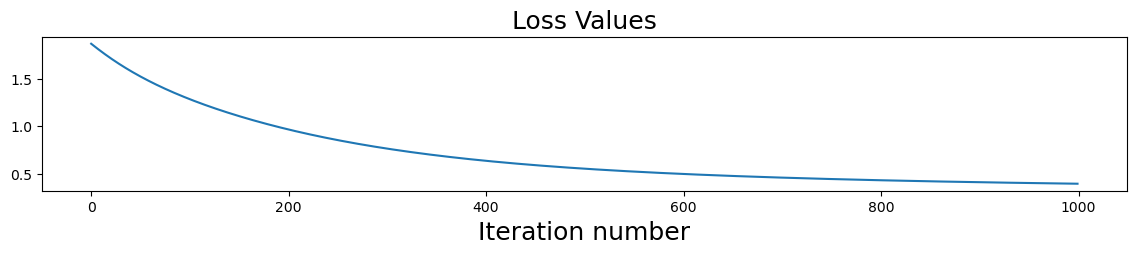

In [23]:
importlib.reload(homework10)
model, lossvalues = homework10.train_neuralnet(features, labels, 1000)
print(model)
fig = plt.figure(figsize=(14,2))
subplot = fig.subplots(1,1)
subplot.plot(lossvalues)
subplot.set_title('Loss Values',fontsize=18)
subplot.set_xlabel('Iteration number',fontsize=18)

### Homework 10.3: test_neuralnet

In [133]:
importlib.reload(homework10)
help(homework10.test_neuralnet)

Help on function test_neuralnet in module homework10:

test_neuralnet(model, features)
    @param:
    model - a neural net model created in pytorch, and trained
    features (NFRAMES, NFEATS) - numpy array
    @return:
    probabilities (NFRAMES, NLABELS) - model output, transformed by softmax, detach().numpy().



Text(0.5, 0, 'Time (frame index)')

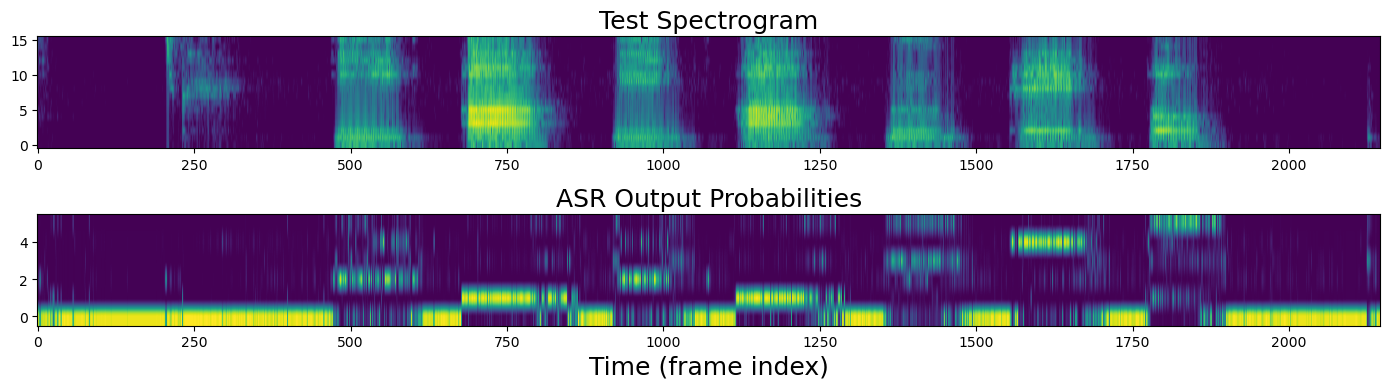

In [25]:
importlib.reload(homework10)
probabilities = homework10.test_neuralnet(model, testsgram)
fig = plt.figure(figsize=(14,4), layout='tight')
subplots = fig.subplots(2,1)
subplots[0].imshow(testsgram.transpose(), aspect='auto', origin='lower')
subplots[0].set_title('Test Spectrogram',fontsize=18)
subplots[1].imshow(probabilities.transpose(), aspect='auto', origin='lower')
subplots[1].set_title('ASR Output Probabilities',fontsize=18)
subplots[1].set_xlabel('Time (frame index)',fontsize=18)


### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework10.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.

In [26]:
import importlib, grade
importlib.reload(grade)

/Users/jhasegaw/kcgi/intro_speech_understanding/lec10/grade.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a', sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/Users/jhasegaw/kcgi/intro_speech_understanding/lec10/grade.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  testspeech, Fs = librosa.load('test.m4a', sr=8000)
...
----------------------------------------------------------------------
Ran 3 tests in 3.506s

OK
/Users/jhasegaw/kcgi/intro_speech_understanding/lec10/grade.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a', sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core

3 successes out of 3 tests run
Score: 100%


..
----------------------------------------------------------------------
Ran 3 tests in 3.275s

OK


3 successes out of 3 tests run
Score: 100%


<module 'grade' from '/Users/jhasegaw/kcgi/intro_speech_understanding/lec10/grade.py'>

Once you've got it working, `git commit` then `git push` to your own repository on github, then copy and paste the URL to Canvas.